##Imports

In [0]:
import numpy as np
from keras.optimizers import SGD,RMSprop,Adam
import h5py
from keras.models import Sequential
from keras.applications.resnet50 import ResNet50
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

import keras.backend as K
K.set_image_data_format('channels_last')
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

## Mounting Google Drive


In [0]:
# Install a Drive FUSE wrapper.

# https://github.com/astrada/google-drive-ocamlfuse

!apt-get install -y -qq software-properties-common python-software-properties module-init-tools

!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null

!apt-get update -qq 2>&1 > /dev/null

!apt-get -y install -qq google-drive-ocamlfuse fuse

E: Package 'python-software-properties' has no installation candidate
Selecting previously unselected package google-drive-ocamlfuse.
(Reading database ... 131323 files and directories currently installed.)
Preparing to unpack .../google-drive-ocamlfuse_0.7.1-0ubuntu3~ubuntu18.04.1_amd64.deb ...
Unpacking google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Setting up google-drive-ocamlfuse (0.7.1-0ubuntu3~ubuntu18.04.1) ...
Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


In [0]:
# Generate auth tokens for Colab

from google.colab import auth 
auth.authenticate_user()

In [0]:
# Generate creds for the Drive FUSE library.

from oauth2client.client import GoogleCredentials 
creds = GoogleCredentials.get_application_default()

import getpass

!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL

vcode = getpass.getpass()

!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
# Create a directory and mount Google Drive using that directory.

!mkdir -p drive

!google-drive-ocamlfuse drive 

##Loading Data Set

###Loading Data set function **Definition**

In [0]:
def load_dataset():
    path_to_train = "drive/DL_labs/Lab_3/assignment3_train.h5"
    path_to_test = "drive/DL_labs/Lab_3/assignment3_test.h5"
    train_dataset = h5py.File(path_to_train)
    train_x = np.array(train_dataset['train_set_x'][:])
    train_y = np.array(train_dataset['train_set_y'][:])

    test_dataset = h5py.File(path_to_test)
    test_x = np.array(test_dataset['test_set_x'][:])
    test_y = np.array(test_dataset['test_set_y'][:])

    # y reshaped
    train_y = train_y.reshape((1, train_x.shape[0]))
    test_y = test_y.reshape((1, test_y.shape[0]))

    return train_x, train_y, test_x, test_y 

###Running Data set loading function

In [0]:
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig = load_dataset()

##Preprocessing the data

###Normalization

In [0]:
# Normalize image vectors
X_train = X_train_orig/255.
X_test = X_test_orig/255.

###Reshaping

In [0]:
# Reshape
Y_train = Y_train_orig.T
Y_test = Y_test_orig.T

###Viewing the Data

In [0]:
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of training examples = 600
number of test examples = 150
X_train shape: (600, 64, 64, 3)
Y_train shape: (600, 1)
X_test shape: (150, 64, 64, 3)
Y_test shape: (150, 1)


##Happy Model Implementation

###Defining the Model Function

In [0]:
def HappyModel(input_shape, model_name, allow_pretrained_weights):
    """
    Implementation of the HappyModel.
    
    Arguments:
    input_shape -- shape of the images of the dataset

    Returns:
    model -- a Model() instance in Keras
    """
    X_input = Input(input_shape)
    
    # Using Resnet model - without allowing the pretrained weights 
    if(model_name == 'resnet' and allow_pretrained_weights == False):
      base_model = ResNet50(input_tensor = X_input, weights= None, include_top=False)
      X = base_model.output
      X = GlobalAveragePooling2D()(X)
      X = Dropout(0.7)(X)
      X = Dense(1, activation='sigmoid', name='fc')(X)
      model = Model(inputs = X_input, outputs = X, name = 'HappyModel')
    
    # Using Resnet model - allowing the pretrained weights
    elif(model_name == 'resnet' and allow_pretrained_weights == True):
      base_model = ResNet50(input_tensor = X_input, weights = 'imagenet', include_top=False)
      X = base_model.output
      X = GlobalAveragePooling2D()(X)
      X = Dropout(0.7)(X)
      X = Dense(1, activation='sigmoid', name='fc')(X)
      model = Model(inputs = X_input, outputs = X, name = 'HappyModel')
      
    # Using VGG19 model - without allowing the pretrained weights
    elif(model_name == 'vgg' and allow_pretrained_weights == False):
      base_model = VGG16(weights= None, include_top=False, input_shape= (64,64,3))
      model = Sequential()
      model.add(base_model)
      model.add(layers.Flatten())
      model.add(layers.Dense(512, activation='relu'))
      model.add(layers.Dense(1, activation='sigmoid'))      
    # Using VGG19 model - allowing the pretrained weights
    elif(model_name == 'vgg' and allow_pretrained_weights == True):
      base_model = VGG16(weights= 'imagenet', include_top=False, input_shape= (64,64,3))
      model = Sequential()
      model.add(base_model)
      model.add(layers.Flatten())
      model.add(layers.Dense(512, activation='relu'))
      model.add(layers.Dense(1, activation='sigmoid'))  
    
    # Simple CNN model
    else:
      X = ZeroPadding2D((3, 3))(X_input)
      X = Conv2D(32, (7, 7), strides = (1, 1), name = 'conv0')(X)
      X = BatchNormalization(axis = 3, name = 'bn0')(X)
      X = Activation('relu')(X)
      X = MaxPooling2D((2, 2), name='max_pool')(X)
      X = Flatten()(X)
      X = Dense(1, activation='sigmoid', name='fc')(X)
      model = Model(inputs = X_input, outputs = X, name = 'HappyModel')

    return model

##Simple CNN Model

###Create Simple CNN Model

In [0]:
input_shape = X_train.shape[1:]
model_name = "CNN"
allow_pretrained_weights = False
happyModel = HappyModel(input_shape, model_name, allow_pretrained_weights)

###Compile the Model

In [0]:
happyModel.compile(optimizer = "Adam", loss = "binary_crossentropy", metrics = ["accuracy"])

###Train the Model

Train on 480 samples, validate on 120 samples
Epoch 1/10
480/480 [==============================] - 1s 2ms/step - loss: 1.0717 - acc: 0.6792 - val_loss: 0.1665 - val_acc: 0.9417
Epoch 2/10
480/480 [==============================] - 0s 692us/step - loss: 0.1935 - acc: 0.9167 - val_loss: 0.8591 - val_acc: 0.5750
Epoch 3/10
480/480 [==============================] - 0s 676us/step - loss: 0.1999 - acc: 0.9125 - val_loss: 0.1403 - val_acc: 0.9417
Epoch 4/10
480/480 [==============================] - 0s 679us/step - loss: 0.1210 - acc: 0.9479 - val_loss: 0.1029 - val_acc: 0.9500
Epoch 5/10
480/480 [==============================] - 0s 706us/step - loss: 0.1071 - acc: 0.9667 - val_loss: 0.1065 - val_acc: 0.9500
Epoch 6/10
480/480 [==============================] - 0s 666us/step - loss: 0.1163 - acc: 0.9542 - val_loss: 0.1051 - val_acc: 0.9500
Epoch 7/10
480/480 [==============================] - 0s 682us/step - loss: 0.0933 - acc: 0.9812 - val_loss: 0.1510 - val_acc: 0.9333
Epoch 8/10
480/480

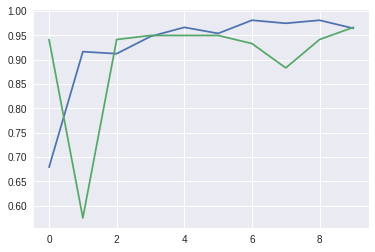

In [0]:
hist = happyModel.fit(x = X_train, y = Y_train, epochs = 10, batch_size = 16, validation_split = 0.2)
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])

###Test the Model

In [0]:
preds = happyModel.evaluate(x = X_test, y = Y_test)
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

150/150 [==============================] - 0s 295us/step

Loss = 0.1184446769952774
Test Accuracy = 0.9533333349227905


##ResNet Model - Without pretrained data

###Create ResNet Model

In [0]:
input_shape = X_train.shape[1:]
model_name = "resnet"
allow_pretrained_weights = False
happyModel = HappyModel(input_shape, model_name, allow_pretrained_weights)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


###Compile the Model

In [0]:
happyModel.compile(optimizer = "Adam", loss = "binary_crossentropy", metrics = ["accuracy"])

###Train the Model

Train on 540 samples, validate on 60 samples
Epoch 1/15
540/540 [==============================] - 52s 96ms/step - loss: 0.9332 - acc: 0.7407 - val_loss: 7.6702 - val_acc: 0.4833
Epoch 2/15
540/540 [==============================] - 7s 13ms/step - loss: 0.4583 - acc: 0.8741 - val_loss: 2.0890 - val_acc: 0.7833
Epoch 3/15
540/540 [==============================] - 7s 13ms/step - loss: 0.2211 - acc: 0.9463 - val_loss: 0.1637 - val_acc: 0.9667
Epoch 4/15
540/540 [==============================] - 7s 13ms/step - loss: 0.1900 - acc: 0.9463 - val_loss: 0.4220 - val_acc: 0.9667
Epoch 5/15
540/540 [==============================] - 7s 13ms/step - loss: 0.0773 - acc: 0.9741 - val_loss: 0.0879 - val_acc: 0.9667
Epoch 6/15
540/540 [==============================] - 7s 13ms/step - loss: 0.0638 - acc: 0.9796 - val_loss: 0.2903 - val_acc: 0.9500
Epoch 7/15
540/540 [==============================] - 7s 13ms/step - loss: 0.2311 - acc: 0.9481 - val_loss: 0.0459 - val_acc: 0.9833
Epoch 8/15
540/540 [===

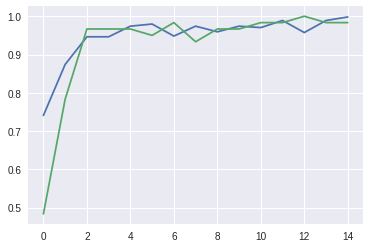

In [0]:
hist = happyModel.fit(x = X_train, y = Y_train, epochs = 15, batch_size = 16, validation_split = 0.1)
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])

###Test the Model

In [0]:
preds = happyModel.evaluate(x = X_test, y = Y_test)
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

150/150 [==============================] - 0s 2ms/step

Loss = 0.191583316201965
Test Accuracy = 0.9600000039736429


##ResNet Model - ImageNet Pretrained data

###Create ResNet Model

In [0]:
input_shape = X_train.shape[1:]
model_name = "resnet"
allow_pretrained_weights = True
happyModel = HappyModel(input_shape, model_name, allow_pretrained_weights)

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


###Compile the Model

In [0]:
happyModel.compile(optimizer = "Adam", loss = "binary_crossentropy", metrics = ["accuracy"])

###Train the Model

Train on 540 samples, validate on 60 samples
Epoch 1/15
540/540 [==============================] - 34s 63ms/step - loss: 0.5233 - acc: 0.8000 - val_loss: 3.5643 - val_acc: 0.7167
Epoch 2/15
540/540 [==============================] - 5s 9ms/step - loss: 0.2121 - acc: 0.9185 - val_loss: 0.4969 - val_acc: 0.9500
Epoch 3/15
540/540 [==============================] - 5s 9ms/step - loss: 0.1238 - acc: 0.9611 - val_loss: 0.4998 - val_acc: 0.9333
Epoch 4/15
540/540 [==============================] - 5s 9ms/step - loss: 0.1499 - acc: 0.9352 - val_loss: 2.6718 - val_acc: 0.8000
Epoch 5/15
540/540 [==============================] - 5s 9ms/step - loss: 0.1327 - acc: 0.9704 - val_loss: 2.3115 - val_acc: 0.8000
Epoch 6/15
540/540 [==============================] - 5s 9ms/step - loss: 0.1990 - acc: 0.9389 - val_loss: 0.2068 - val_acc: 0.9500
Epoch 7/15
540/540 [==============================] - 5s 9ms/step - loss: 0.1384 - acc: 0.9611 - val_loss: 0.6215 - val_acc: 0.9000
Epoch 8/15
540/540 [=========

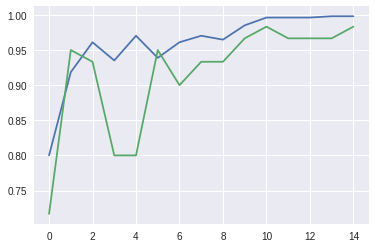

In [0]:
hist = happyModel.fit(x = X_train, y = Y_train, epochs = 15, batch_size = 32, validation_split = 0.1)
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])

###Test the Model

In [0]:
preds = happyModel.evaluate(x = X_test, y = Y_test)
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

150/150 [==============================] - 0s 2ms/step

Loss = 0.095139221213758
Test Accuracy = 0.9866666642824808


##VGG Model - Without Pretrained data

###Create the Model

In [0]:
input_shape = X_train.shape[1:]
model_name = "vgg"
allow_pretrained_weights = False
happyModel = HappyModel(input_shape, model_name, allow_pretrained_weights)

###Compile the Model

In [0]:
adam=Adam(lr=0.0001)
happyModel.compile(optimizer = adam, loss = "binary_crossentropy", metrics = ["accuracy"])

###Training the Model

Train on 540 samples, validate on 60 samples
Epoch 1/15
540/540 [==============================] - 47s 87ms/step - loss: 0.6937 - acc: 0.4593 - val_loss: 0.6932 - val_acc: 0.4833
Epoch 2/15
540/540 [==============================] - 4s 7ms/step - loss: 0.6932 - acc: 0.5019 - val_loss: 0.6932 - val_acc: 0.4833
Epoch 3/15
540/540 [==============================] - 3s 6ms/step - loss: 0.6932 - acc: 0.4648 - val_loss: 0.6929 - val_acc: 0.7000
Epoch 4/15
540/540 [==============================] - 3s 6ms/step - loss: 0.6924 - acc: 0.5315 - val_loss: 0.6920 - val_acc: 0.4833
Epoch 5/15
540/540 [==============================] - 3s 6ms/step - loss: 0.6715 - acc: 0.5722 - val_loss: 0.5649 - val_acc: 0.8500
Epoch 6/15
540/540 [==============================] - 3s 6ms/step - loss: 0.5352 - acc: 0.7074 - val_loss: 0.5892 - val_acc: 0.6000
Epoch 7/15
540/540 [==============================] - 3s 6ms/step - loss: 0.3690 - acc: 0.8278 - val_loss: 0.3888 - val_acc: 0.8000
Epoch 8/15
540/540 [=========

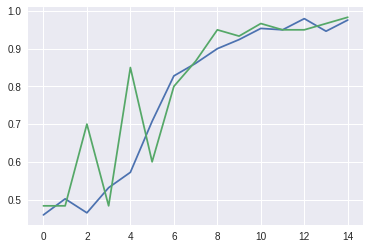

In [0]:
hist = happyModel.fit(x = X_train, y = Y_train, epochs = 15, batch_size = 16, validation_split = 0.1)
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])

###Testing the Model

In [0]:
preds = happyModel.evaluate(x = X_test, y = Y_test)
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

150/150 [==============================] - 1s 5ms/step

Loss = 0.1685661635796229
Test Accuracy = 0.9533333309491475


##VGG Model - ImageNet Pretrained data

###Create the Model

In [0]:
input_shape = X_train.shape[1:]
model_name = "vgg"
allow_pretrained_weights = True
happyModel = HappyModel(input_shape, model_name, allow_pretrained_weights)

58892288/58889256 [==============================] - 1s 0us/step


###Compile the Model

In [0]:
adam=Adam(lr=0.0001)
happyModel.compile(optimizer = adam, loss = "binary_crossentropy", metrics = ["accuracy"])

###Train the Model

Train on 540 samples, validate on 60 samples
Epoch 1/15
540/540 [==============================] - 48s 88ms/step - loss: 0.7220 - acc: 0.5463 - val_loss: 0.6295 - val_acc: 0.8500
Epoch 2/15
540/540 [==============================] - 2s 4ms/step - loss: 0.5711 - acc: 0.6870 - val_loss: 0.3652 - val_acc: 0.8333
Epoch 3/15
540/540 [==============================] - 2s 4ms/step - loss: 0.3848 - acc: 0.7981 - val_loss: 0.3557 - val_acc: 0.8167
Epoch 4/15
540/540 [==============================] - 2s 4ms/step - loss: 0.2434 - acc: 0.8963 - val_loss: 0.1504 - val_acc: 0.9500
Epoch 5/15
540/540 [==============================] - 2s 4ms/step - loss: 0.1844 - acc: 0.9352 - val_loss: 0.2916 - val_acc: 0.9667
Epoch 6/15
540/540 [==============================] - 2s 4ms/step - loss: 0.1710 - acc: 0.9537 - val_loss: 0.0735 - val_acc: 0.9667
Epoch 7/15
540/540 [==============================] - 2s 4ms/step - loss: 0.0803 - acc: 0.9685 - val_loss: 0.0590 - val_acc: 0.9667
Epoch 8/15
540/540 [=========

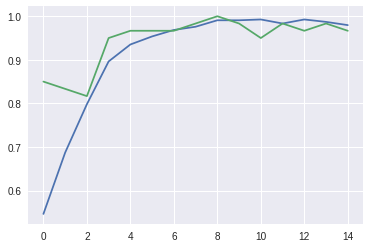

In [0]:
hist = happyModel.fit(x = X_train, y = Y_train, epochs = 15, batch_size = 32, validation_split = 0.1)
plt.plot(hist.history['acc'])
plt.plot(hist.history['val_acc'])

###Test the Model

In [0]:
preds = happyModel.evaluate(x = X_test, y = Y_test)
print()
print ("Loss = " + str(preds[0]))
print ("Test Accuracy = " + str(preds[1]))

150/150 [==============================] - 0s 2ms/step

Loss = 0.04377186993757884
Test Accuracy = 0.980000003973643
